In [2]:
import pandas as pd
import numpy as np
import sklearn

In [116]:
pd.options.display.max_colwidth = 100

In [6]:
path = lambda x : 'data/'+x

In [118]:
df_nodes = pd.read_csv(path("network_nodes.csv"),  sep=';',)
df_rail = pd.read_csv(path("network_rail.csv"),  sep=';',)
df_day = pd.read_csv(path("network_temporal_day.csv"),  sep=';',)
df_week = pd.read_csv(path("network_temporal_week.csv"),  sep=';',)
df_walk = pd.read_csv(path("network_walk.csv"),  sep=';',)
stats = pd.read_csv(path("stats.csv"),  sep=';',)

In [8]:
df_week

,from_stop_I,to_stop_I,dep_time_ut,arr_time_ut,route_type,trip_I,seq,route_I
0,6507,6502,1461552300,1461552660,3,1,1,1
1,6502,5491,1461552660,1461553140,3,1,2,1
2,5491,5534,1461553140,1461553560,3,1,3,1
3,5534,5572,1461553560,1461553860,3,1,4,1
4,5572,5477,1461553860,1461553980,3,1,5,1
...,...,...,...,...,...,...,...,...
6723256,7568,7481,1461958080,1461958200,3,195916,22,50
6723257,7481,7480,1461958200,1461958260,3,195916,23,50
6723258,7480,7478,1461958260,1461958380,3,195916,24,50
6723259,7478,7479,1461958380,1461958440,3,195916,25,50


In [119]:
filt = df_week["route_type"] == 2
df_week = df_week[filt]

In [120]:
df_day = df_day[df_day['route_type']==2]

In [121]:
df_week = df_week.append(df_day,ignore_index=True)

In [122]:
df_week.drop_duplicates(inplace=True)

In [123]:
merge = pd.merge(left=df_week, right=df_nodes, how='left', left_on='from_stop_I', right_on='stop_I')

In [124]:
merge.rename(columns={"lat": "lat_from","lon": "lon_from","name": "name_from"},inplace=True)

In [125]:
merge = pd.merge(left=merge, right=df_nodes, how='left', left_on='to_stop_I', right_on='stop_I')

In [126]:
merge.rename(columns={"lat": "lat_to","lon": "lon_to","name": "name_to"},inplace=True)

In [127]:
merge["trip_duration_mins"] = (merge["arr_time_ut"] - merge["dep_time_ut"]) / 60

In [128]:
merge = pd.merge(left=merge, right=df_rail, how='left', left_on=['from_stop_I','to_stop_I'], right_on=['from_stop_I','to_stop_I'])

In [129]:
merge["duration_avg"] = merge["duration_avg"]/60

In [130]:
merge['dep_date'] = pd.to_datetime(merge["dep_time_ut"],unit='s')
merge['arr_date'] = pd.to_datetime(merge["arr_time_ut"],unit='s')

In [131]:
merge = pd.merge(left=merge, right=df_walk, how='left', left_on=['from_stop_I','to_stop_I'], right_on=['from_stop_I','to_stop_I'])

In [132]:
(merge['from_stop_I']!=merge['stop_I_x']).value_counts()

False    494084
True         14
dtype: int64

In [133]:
merge[filt].index

C:\Users\Dobler\anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Int64Index([], dtype='int64')

In [134]:
merge.drop(merge[filt].index,inplace=True)

C:\Users\Dobler\anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [135]:
merge[filt]

C:\Users\Dobler\anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,from_stop_I,to_stop_I,dep_time_ut,arr_time_ut,route_type,trip_I,seq,route_I,stop_I_x,lat_from,...,name_to,trip_duration_mins,d_x,duration_avg,n_vehicles,route_I_counts,dep_date,arr_date,d_y,d_walk


In [136]:
(merge['from_stop_I']!=merge['stop_I_x']).value_counts()

False    494084
True         14
dtype: int64

In [137]:
merge.drop(columns=['stop_I_x'],inplace=True)

In [138]:
filt=(merge['to_stop_I']!=merge['stop_I_y'])


In [139]:
merge.drop(merge[filt].index,inplace=True)

In [140]:
merge.drop(columns=['stop_I_y'],inplace=True)

In [141]:
df_tst = pd.merge(left=df_week, right=df_walk,how='left',on=['from_stop_I','to_stop_I'])


In [142]:
no_nulls=df_tst.d.isnull().sum()
total = df_week.shape[0]
total - no_nulls

21852

In [143]:
filt = ~merge['d_y'].isna() & ~merge['d_x'].isna()
filtered = merge[filt][['d_y','d_x']]

In [144]:
import numpy as np
filtered['dif'] = np.absolute((filtered['d_x'] - filtered['d_y']))

In [145]:
filt = merge['d_y'].isna() & merge['d_x'].isna()

In [146]:
merge.drop(merge[filt].index,inplace=True)

In [147]:
filtered = merge[['d_y','d_walk','d_x']]

In [148]:
filt = ~filtered['d_y'].isna() & ~filtered['d_x'].isna() & ~filtered['d_walk'].isna()
filtered = filtered[filt]

In [149]:
merge.drop(columns='d_y',inplace=True)

In [150]:
merge.rename(columns={'d_x':'d'},inplace=True)

In [151]:
merge.drop(columns=['d_walk'],inplace=True)

In [152]:
merge

,from_stop_I,to_stop_I,dep_time_ut,arr_time_ut,route_type,trip_I,seq,route_I,lat_from,lon_from,...,lat_to,lon_to,name_to,trip_duration_mins,d,duration_avg,n_vehicles,route_I_counts,dep_date,arr_date
0,190,209,1461610440,1461610620,2,57375,1,1018,52.531677,13.388800,...,52.544745,13.378731,S Humboldthain (Berlin),3.0,1606.0,2.366972,327.0,"1024:63,1026:28,1018:65,1020:55,1021:62,1023:54",2016-04-25 18:54:00,2016-04-25 18:57:00
1,209,188,1461610620,1461610680,2,57375,2,1018,52.544745,13.378731,...,52.548641,13.388377,S+U Gesundbrunnen Bhf (Berlin),1.0,783.0,1.354740,327.0,"1024:63,1026:28,1018:65,1020:55,1021:62,1023:54",2016-04-25 18:57:00,2016-04-25 18:58:00
2,188,1979,1461610740,1461610860,2,57375,3,1018,52.548641,13.388377,...,52.554757,13.397845,S Bornholmer Str. (Berlin),2.0,935.0,1.785714,294.0,"1024:63,1018:64,1020:51,1021:63,1023:53",2016-04-25 18:59:00,2016-04-25 19:01:00
3,1979,2085,1461610860,1461610980,2,57375,4,1018,52.554757,13.397845,...,52.564977,13.393156,S Wollankstr. (Berlin),2.0,1181.0,2.000000,221.0,"1024:63,1057:43,1018:64,1020:51",2016-04-25 19:01:00,2016-04-25 19:03:00
4,2085,1622,1461610980,1461611100,2,57375,5,1018,52.564977,13.393156,...,52.571905,13.380247,S Schönholz (Berlin),2.0,1165.0,1.520362,221.0,"1024:63,1057:43,1018:64,1020:51",2016-04-25 19:03:00,2016-04-25 19:05:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494093,7167,7186,1461759780,1461760680,2,195581,2,1233,52.317273,13.232617,...,52.390796,13.513527,S Flughafen Berlin-Schönefeld Bhf,15.0,20779.0,14.300000,20.0,1233:20,2016-04-27 12:23:00,2016-04-27 12:38:00
494094,7186,7182,1461760860,1461761760,2,195581,3,1233,52.390796,13.513527,...,52.296925,13.630573,S Königs Wusterhausen Bhf,15.0,13136.0,15.190476,21.0,"1233:20,1235:1",2016-04-27 12:41:00,2016-04-27 12:56:00
494095,5478,7167,1461932220,1461932520,2,195581,1,1233,52.323652,13.139744,...,52.317273,13.232617,"Ludwigsfelde, Struveshof Bhf",5.0,6359.0,5.000000,20.0,1233:20,2016-04-29 12:17:00,2016-04-29 12:22:00
494096,7167,7186,1461932580,1461933480,2,195581,2,1233,52.317273,13.232617,...,52.390796,13.513527,S Flughafen Berlin-Schönefeld Bhf,15.0,20779.0,14.300000,20.0,1233:20,2016-04-29 12:23:00,2016-04-29 12:38:00


In [153]:
merge.duration_avg.describe()

count    493264.000000
mean          2.211983
std           1.744114
min           1.000000
25%           1.619178
50%           2.000000
75%           2.006383
max          43.000000
Name: duration_avg, dtype: float64

In [154]:
merge.duration_avg.max() , merge.duration_avg.min()

(43.0, 1.0)

In [100]:
delys = np.array([5, 10, 30, 60, 2, 0])

In [101]:
normalized = (delys - delys.min()) / (delys.max() - delys.min())
normalized

array([0.08333333, 0.16666667, 0.5       , 1.        , 0.03333333,
       0.        ])

In [102]:
disrubtionCategory = {
    "door":{
        "delay":3,
        "probability": .0245
    },
    "brake":{
        "delay":5,
        "probability": .0245
    },
    "fire":{
        "delay":15,
        "probability": .0005
    },
    "collision":{
        "delay":20,
        "probability": .0005
    },
    "other":{
        "delay":1,
        "probability": .05
    },
    "none":{
        "delay":0,
        "probability": .90
    }
}

In [196]:
disrubtionProbability = [value["probability"] for value in disrubtionCategory.values()]
disrubtionChoice = [key for key in disrubtionCategory.keys()]
disrubtion = []
n,o,c,f,b,d = 0,0,0,0,0,0
for i in range (len(merge)):
    if o <= len(merge)*.05:
        disrubtion.append('other')
        o = o + 1
    elif c <= len(merge)*.0005:
        disrubtion.append('collision')
        c = c + 1
    elif f <= len(merge)*.0005:
        disrubtion.append('fire')
        f = f + 1
    elif b <= len(merge)*.0245:
        disrubtion.append('brake')
        b = b + 1
    elif d <= len(merge)*.0245:
        disrubtion.append('door')
        d = d + 1
    elif n <= len(merge)*0.9:
        disrubtion.append('none')
        n= n + 1

In [199]:
merge.sort_values(by='dep_date',inplace=True)

In [200]:
merge["disrubtion"] = disrubtion

In [201]:
merge

,from_stop_I,to_stop_I,dep_time_ut,arr_time_ut,route_type,trip_I,seq,route_I,lat_from,lon_from,...,lon_to,name_to,trip_duration_mins,d,duration_avg,n_vehicles,route_I_counts,dep_date,arr_date,disrubtion
143951,2933,2911,1461548700,1461548880,2,59855,1,1041,52.454614,13.510155,...,13.489511,S Baumschulenweg (Berlin),3.0,2011.0,2.319648,341.0,"1057:43,1058:61,1059:4,1036:53,1037:6,1038:64,1041:1,1043:2,1044:11,1045:9,1046:21,1047:3,1054:63",2016-04-25 01:45:00,2016-04-25 01:48:00,other
336808,6507,6297,1461548820,1461548940,2,67700,1,1233,52.390935,13.067162,...,13.036304,"Potsdam, Charlottenhof Bhf",2.0,2108.0,2.254717,106.0,"1232:32,1233:20,1234:17,1276:21,1231:16",2016-04-25 01:47:00,2016-04-25 01:49:00,other
143952,2911,1414,1461548880,1461549000,2,59855,2,1041,52.467585,13.489511,...,13.467534,S Köllnische Heide (Berlin),2.0,1500.0,2.358824,170.0,"1041:1,1043:2,1044:11,1045:9,1046:21,1047:3,1036:53,1037:6,1038:64",2016-04-25 01:48:00,2016-04-25 01:50:00,other
346619,1878,1880,1461549000,1461549180,2,69032,1,1282,52.520273,13.387158,...,13.411272,S+U Alexanderplatz Bhf (Berlin),3.0,1639.0,2.440000,100.0,"1282:3,1235:1,1301:37,1338:20,1276:2,1309:19,1230:18",2016-04-25 01:50:00,2016-04-25 01:53:00,other
336809,6297,5478,1461549000,1461550260,2,67700,2,1233,52.393007,13.036304,...,13.139744,"Saarmund, Bahnhof",21.0,10443.0,21.000000,1.0,1233:1,2016-04-25 01:50:00,2016-04-25 02:11:00,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337140,659,521,1462148280,1462148520,2,67782,5,1235,52.549450,13.128974,...,13.197482,S Spandau Bhf (Berlin),4.0,4916.0,3.605263,38.0,"1226:18,1235:1,1230:19",2016-05-02 00:18:00,2016-05-02 00:22:00,none
337141,521,356,1462148640,1462149000,2,67782,6,1235,52.534802,13.197482,...,13.299069,S+U Jungfernheide Bhf (Berlin),6.0,6897.0,5.089286,56.0,"1281:10,1226:16,1340:20,1229:10",2016-05-02 00:24:00,2016-05-02 00:30:00,none
337142,356,188,1462149060,1462149480,2,67782,7,1235,52.530279,13.299069,...,13.388377,S+U Gesundbrunnen Bhf (Berlin),7.0,6382.0,8.200000,10.0,1281:10,2016-05-02 00:31:00,2016-05-02 00:38:00,none
337143,188,2391,1462149540,1462150200,2,67782,8,1235,52.548641,13.388377,...,13.498233,S+U Lichtenberg Bhf (Berlin),11.0,8551.0,10.000000,1.0,1321:1,2016-05-02 00:39:00,2016-05-02 00:50:00,none


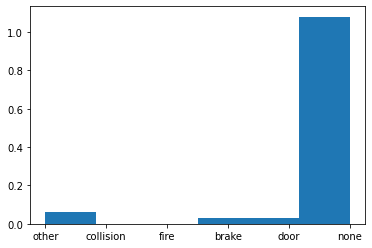

In [202]:
import matplotlib.pyplot as plt
plt.hist(merge["disrubtion"], 6, density=True)
plt.show()

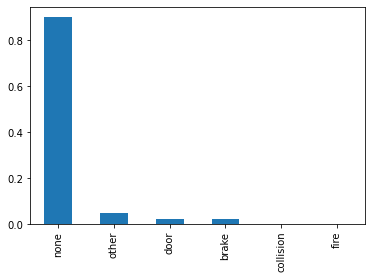

In [203]:
merge["disrubtion"].value_counts(normalize=True).plot(kind='bar')

In [204]:
merge["disrubtion"].value_counts()

none         443936
other         24664
door          12085
brake         12085
collision       247
fire            247
Name: disrubtion, dtype: int64

In [205]:
merge.disrubtion.map({ key:value["delay"] for key,value in disrubtionCategory.items()}).astype('float64')*60

143951    60.0
336808    60.0
143952    60.0
346619    60.0
336809    60.0
          ... 
337140     0.0
337141     0.0
337142     0.0
337143     0.0
337145     0.0
Name: disrubtion, Length: 493264, dtype: float64

In [215]:
merge[['disrubtion']]

,disrubtion
143951,other
336808,other
143952,other
346619,other
336809,other
...,...
337140,none
337141,none
337142,none
337143,none


In [207]:
merge["duration_avg_disrubtion"] = merge.duration_avg.add(merge.disrubtion.map({ key:value["delay"] for key,value in disrubtionCategory.items()}).astype('float64')*60)

In [208]:
merge[merge.disrubtion == "none"][['disrubtion','duration_avg_disrubtion','duration_avg']]

,disrubtion,duration_avg_disrubtion,duration_avg
78907,none,2.000000,2.000000
291980,none,1.674330,1.674330
444635,none,1.122010,1.122010
255098,none,1.657224,1.657224
246430,none,1.497778,1.497778
...,...,...,...
337140,none,3.605263,3.605263
337141,none,5.089286,5.089286
337142,none,8.200000,8.200000
337143,none,10.000000,10.000000


In [216]:
merge['delay']=merge.disrubtion.map({ key:value["delay"] for key,value in disrubtionCategory.items()}).astype('float64')*60

In [217]:
merge[merge.disrubtion == "collision"][['disrubtion','duration_avg_disrubtion','duration_avg','delay']]

,disrubtion,duration_avg_disrubtion,duration_avg,delay
169220,collision,3602.000000,2.000000,3600.0
296459,collision,3602.139130,2.139130,3600.0
145411,collision,3601.857143,1.857143,3600.0
134977,collision,3601.160920,1.160920,3600.0
199618,collision,3601.340909,1.340909,3600.0
...,...,...,...,...
58130,collision,3601.280488,1.280488,3600.0
267767,collision,3601.343750,1.343750,3600.0
375549,collision,3602.626471,2.626471,3600.0
17608,collision,3602.000000,2.000000,3600.0


In [218]:
merge

,from_stop_I,to_stop_I,dep_time_ut,arr_time_ut,route_type,trip_I,seq,route_I,lat_from,lon_from,...,trip_duration_mins,d,duration_avg,n_vehicles,route_I_counts,dep_date,arr_date,disrubtion,duration_avg_disrubtion,delay
143951,2933,2911,1461548700,1461548880,2,59855,1,1041,52.454614,13.510155,...,3.0,2011.0,2.319648,341.0,"1057:43,1058:61,1059:4,1036:53,1037:6,1038:64,1041:1,1043:2,1044:11,1045:9,1046:21,1047:3,1054:63",2016-04-25 01:45:00,2016-04-25 01:48:00,other,62.319648,60.0
336808,6507,6297,1461548820,1461548940,2,67700,1,1233,52.390935,13.067162,...,2.0,2108.0,2.254717,106.0,"1232:32,1233:20,1234:17,1276:21,1231:16",2016-04-25 01:47:00,2016-04-25 01:49:00,other,62.254717,60.0
143952,2911,1414,1461548880,1461549000,2,59855,2,1041,52.467585,13.489511,...,2.0,1500.0,2.358824,170.0,"1041:1,1043:2,1044:11,1045:9,1046:21,1047:3,1036:53,1037:6,1038:64",2016-04-25 01:48:00,2016-04-25 01:50:00,other,62.358824,60.0
346619,1878,1880,1461549000,1461549180,2,69032,1,1282,52.520273,13.387158,...,3.0,1639.0,2.440000,100.0,"1282:3,1235:1,1301:37,1338:20,1276:2,1309:19,1230:18",2016-04-25 01:50:00,2016-04-25 01:53:00,other,62.440000,60.0
336809,6297,5478,1461549000,1461550260,2,67700,2,1233,52.393007,13.036304,...,21.0,10443.0,21.000000,1.0,1233:1,2016-04-25 01:50:00,2016-04-25 02:11:00,other,81.000000,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337140,659,521,1462148280,1462148520,2,67782,5,1235,52.549450,13.128974,...,4.0,4916.0,3.605263,38.0,"1226:18,1235:1,1230:19",2016-05-02 00:18:00,2016-05-02 00:22:00,none,3.605263,0.0
337141,521,356,1462148640,1462149000,2,67782,6,1235,52.534802,13.197482,...,6.0,6897.0,5.089286,56.0,"1281:10,1226:16,1340:20,1229:10",2016-05-02 00:24:00,2016-05-02 00:30:00,none,5.089286,0.0
337142,356,188,1462149060,1462149480,2,67782,7,1235,52.530279,13.299069,...,7.0,6382.0,8.200000,10.0,1281:10,2016-05-02 00:31:00,2016-05-02 00:38:00,none,8.200000,0.0
337143,188,2391,1462149540,1462150200,2,67782,8,1235,52.548641,13.388377,...,11.0,8551.0,10.000000,1.0,1321:1,2016-05-02 00:39:00,2016-05-02 00:50:00,none,10.000000,0.0


In [219]:
merge.to_csv('data/NeomDataSet_disrubtion.csv', index=False)